In [2]:
# Import TF and TF Hub libraries.
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tf2onnx
import subprocess
import cv2

# Download the model from TF Hub.
model = hub.load("https://www.kaggle.com/models/google/movenet/TensorFlow2/singlepose-lightning/4")
movenet = model.signatures['serving_default']

In [12]:
# Load the input image
image_path = './kyokushi-nanaya.png'
image = tf.io.read_file(image_path)
image = tf.compat.v1.image.decode_jpeg(image)
image = tf.expand_dims(image, axis=0)
# Resize and pad the image to keep the aspect ratio and fit the expected size.
image = tf.cast(tf.image.resize_with_pad(image, 192, 192), dtype=tf.int32)

In [13]:
# Run model inference.
outputs = movenet(image)
# Output is a [1, 1, 17, 3] tensor.
keypoints = outputs['output_0']
print(keypoints[0][0])

tf.Tensor(
[[0.36727607 0.5812892  0.3382075 ]
 [0.34428078 0.60589564 0.41563293]
 [0.34039626 0.5655281  0.38113177]
 [0.35466823 0.6403011  0.40432182]
 [0.3364695  0.5375261  0.3753358 ]
 [0.47575623 0.67586076 0.815754  ]
 [0.44372225 0.47061938 0.6161275 ]
 [0.59732735 0.55252963 0.25787717]
 [0.5347773  0.3918764  0.2246131 ]
 [0.5000789  0.3584857  0.5461282 ]
 [0.4955294  0.3355862  0.3807939 ]
 [0.7746345  0.5625905  0.49802983]
 [0.74924916 0.4175235  0.5020223 ]
 [0.7600435  0.545617   0.14871527]
 [0.732331   0.3160424  0.17471263]
 [0.7236688  0.29664153 0.28401735]
 [0.7417898  0.30024636 0.2414978 ]], shape=(17, 3), dtype=float32)


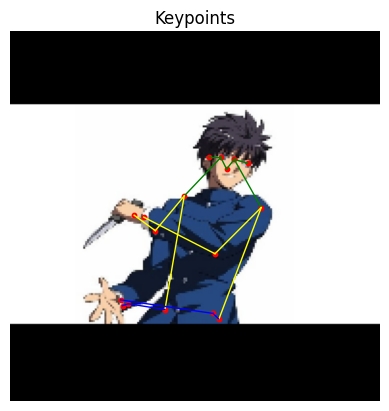

In [14]:
# Reminder:
# 0 = nose
# 1 = left eye
# 2 = right eye
# 3 = left ear
# 4 = right ear
# 5 = left shoulder
# 6 = right shoulder
# 7 = left elbow
# 8 = right elbow
# 9 = left wrist
# 10 = right wrist
# 11 = left hip
# 12 = right hip
# 13 = left knee
# 14 = right knee
# 15 = left ankle
# 16 = right ankle

# 0 connections: 1, 2
# 1 connections: 3, 5
# 2 connections: 4, 6
# 5 connections: 7, 11
# 6 connections: 8, 12
# 7 connections: 9
# 8 connections; 10
# 11 connections: 13
# 12 connections: 14
# 13 connections: 15
# 14 connections: 16
listOfConnections = [[1, 2], [3, 5], [4, 6], [], [], [7, 11], [8, 12], [9], [10], [], [], [13], [14], [15], [16]]

def draw_image(image, keypoints):
    height = image.shape[0]
    width = image.shape[1]

    plt.imshow(image)
    plt.axis("off")
    plt.title("Keypoints")
    keypoints = keypoints.numpy()  # converts entire tensor to NumPy array
    
    # get this initialized to save the positions to use when drawing lines
    xyList = [[0, 0] for _ in range(len(keypoints))]

    for i in range(0, len(keypoints), 1):
        # put in the values, then plot them
        xyList[i] = [round(keypoints[i][1] * width), round(keypoints[i][0] * height)]
        plt.scatter(xyList[i][0], xyList[i][1], c = "red", s = 10)

    # now, draw the lines as listed in "listOfConnections"
    for i in range(0, len(listOfConnections), 1):
        for otherPoint in listOfConnections[i]:
            color = "green" if otherPoint < 7 else "yellow" if otherPoint < 13 else "blue"
            plt.plot([xyList[i][0], xyList[otherPoint][0]], [xyList[i][1], xyList[otherPoint][1]], color = color, linewidth = 1)
    
    plt.show()

# don't need the first dimension here
draw_image(image[0], keypoints[0][0])

In [6]:
print("Now saving model...")
tf.saved_model.save(model, "./movenet_savedmodel", signatures=model.signatures)
result = subprocess.run(["python", "-m", "tf2onnx.convert", "--saved-model", "./movenet_savedmodel", "--output", "./movenet.onnx", "--opset", "14"], capture_output=True, text=True)
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)

Now saving model...


KeyboardInterrupt: 